In [9]:
import math
import random
import numpy as np
import networkx as nx

import re
import networkx as nx
from dataclasses import dataclass
import math
import random
import numpy as np


@dataclass
class Data:
    name: str
    nb_nodes: int
    nb_arcs: int
    nb_tasks: int
    nb_non_req: int
    nb_trucks: int
    truck_capacity: int
    total_cost: int
    depot: int
    graph: nx.DiGraph


def add_arc(G: nx.DiGraph, line: str) -> nx.DiGraph:
    arc = int(re.search(r"arc=(\d+)", line).group(1))
    from_node = int(re.search(r"From=(\d+)", line).group(1))
    to_node = int(re.search(r"to=(\d+)", line).group(1))
    demand = int(re.search(r"Qty=(-?\d+)", line).group(1))
    cost_traversing = int(re.search(r"Trav=(-?\d+)", line).group(1))
    cost_collecting = int(re.search(r"Col= (-?\d+)", line).group(1))
    opposed_arc = int(re.search(r"inv=(\d+)", line).group(1))
    successor_arcs = list(map(int, re.search(r"succ=(.*);", line).group(1).split(",")))
    frequency = int(re.search(r"freq= (\d+)", line).group(1))

    # Check if node exists, if not create it
    if not G.has_node(from_node):
        G.add_node(from_node)
    if not G.has_node(to_node):
        G.add_node(to_node)

    # Removes the arc if it is the same as the opposed arc
    if from_node != to_node:
        G.add_edge(
            from_node,
            to_node,
            arc=arc,
            demand=demand,
            cost_traversing=cost_traversing,
            cost_collecting=cost_collecting,
            opposed_arc=opposed_arc,
            successor_arcs=successor_arcs,
            frequency=frequency,
        )

    return G


def import_data(paht: str) -> Data:

    G = nx.DiGraph()

    with open(paht, "r") as file:
        lines = file.readlines()

        for line in lines:
            if re.match(r"^Name=", line):
                name = re.search(r"=(.*)", line).group(1).strip()
            elif re.match(r"^nbnodes=", line):
                nb_nodes = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^nbarcs=", line):
                nb_arcs = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^nbtasks=", line):
                nb_tasks = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^nbnon_req=", line):
                nb_non_req = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^nbtrucks=", line):
                nb_trucks = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^capacity=", line):
                capacity = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^total_cost=", line):
                total_cost = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^Depot=", line):
                depot = int(re.search(r"=(.*)", line).group(1).strip())
            elif re.match(r"^ arc", line):
                G = add_arc(G, line)

    return Data(
        name=name,
        nb_nodes=nb_nodes,
        nb_arcs=nb_arcs,
        nb_tasks=nb_tasks,
        nb_non_req=nb_non_req,
        nb_trucks=nb_trucks,
        truck_capacity=capacity,
        total_cost=total_cost,
        depot=depot,
        graph=G,
    )

In [10]:
data = import_data("/Users/mariacarolina/Documents/thesis/gdb9.txt")
G = data.graph

data

Data(name='gdb9', nb_nodes=27, nb_arcs=103, nb_tasks=51, nb_non_req=0, nb_trucks=10, truck_capacity=81, total_cost=219, depot=1, graph=<networkx.classes.digraph.DiGraph object at 0x12e71a9e0>)

In [11]:
print(data.graph)

DiGraph with 27 nodes and 102 edges


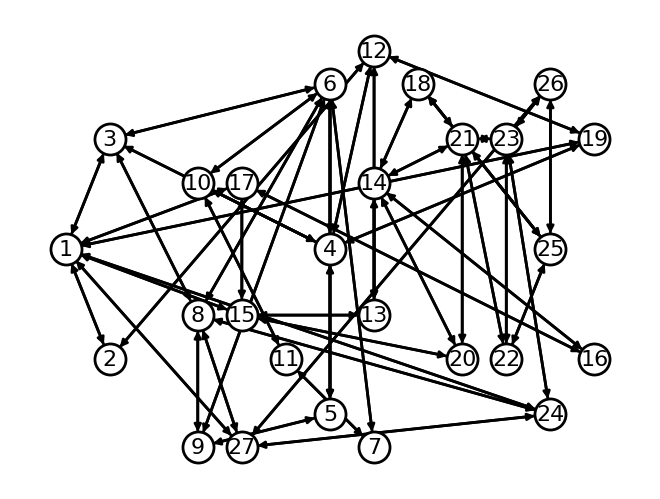

In [23]:
def plot_graph(G: nx.DiGraph, path: list | None = None):
    options = {
        "font_size": 16,
        "node_size": 500,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 2,
        "width": 2,
        "with_labels": True,
    }

    layers = {
        0: [1],
        1: [2, 3],
        2: [5, 4, 6],
        3: [9, 8, 10, 12],
        4: [27, 15, 17,24],
        5: [11, 12],
        6: [5, 4, 6],
        7: [7, 13, 14, 12],
        8: [16, 19, 18],
        9: [20, 21],
        10: [22,23],
        11: [24,25,26],
        12: [16, 19]
    }

    pos = {}
    width = 1.0 / (len(layers) - 1)
    for i, (layer, nodes) in enumerate(layers.items()):
        height = 1.0 / (len(nodes) + 1)
        for j, node in enumerate(nodes):
            pos[node] = (i * width, (j + 1) * height)

    nx.draw(G, pos, **options)

    if path is not None:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="r", width=5)
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color="lightblue", node_size=2000)


plot_graph(G)




## Solution


In [24]:
class SimulatedAnnealing:
    data: Data = None
    current_solution = None
    current_cost = None
    current_cost_components = None
    big_M = None
    max_path_length = None
    G: nx.DiGraph = None

    def __init__(
        self,
        data: Data,
        temperature=1.0,
        min_temperature=0.001,
        alpha=0.9,
        big_M=1e5,
        max_path_length: int = None,
    ):
        self.data = data
        self.temperature = temperature
        self.min_temperature = min_temperature
        self.alpha = alpha
        self.big_M = big_M
        self.max_path_length = (
            max_path_length
            if max_path_length is not None
            else math.ceil(data.nb_arcs / data.nb_trucks) * 2
        )

        self.G = data.graph

    def _generate_random_route(self):
        start_node = self.data.depot
        return self._generate_random_path_recursively(start_node)

    def _generate_random_path_recursively(self, start_node, path=[]):
        """Recursively finds a random path in a directed graph."""
        path = path + [start_node]

        # If we're back at the start and the path has more than 1 node, we're done
        if start_node == self.data.depot and len(path) > 1:
            return path

        neighbors = list(self.G.neighbors(start_node))

        # Randomize the order of neighbours
        random.shuffle(neighbors)

        for next_node in neighbors:
            if next_node not in path or next_node == 1:
                new_path = self._generate_random_path_recursively(next_node, path)
                if new_path:
                    return new_path

        return None

    def _initial_solution(self):
        return [{n: self._generate_random_route() for n in range(data.nb_trucks)} for _ in range(5)]

    def _add_node(self, route: list[int]):
        # select random node in the route to add a node after
        selected_idx = random.randint(0, len(route) - 2)
        selected_node = route[selected_idx]
        next_node = route[selected_idx + 1]

        # Find the shortest path from the possible new node to the next node
        shortest_path_to_next_node = {
            node: nx.shortest_path(G, node, next_node)
            for node in G[selected_node]
            if node != next_node
        }

        new_node_idx = random.choice(list(shortest_path_to_next_node.keys()))

        return (
            route[: selected_idx + 1]
            + shortest_path_to_next_node[new_node_idx][:-1]
            + route[selected_idx + 1 :]
        )

    def _swap_subpath(self, route: list[int], subpath_length: int = 2):
        # Swap two nodes in the route
        lower_bound = 1
        upper_bound = len(route) - subpath_length - 1

        if upper_bound <= lower_bound:
            return route

        g = self.G.copy()

        start_remove_idx = random.randint(lower_bound, upper_bound)
        for node in route[start_remove_idx : start_remove_idx + subpath_length]:
            g.remove_node(node)

        start_node = route[start_remove_idx - 1]
        end_node = route[start_remove_idx + subpath_length + 1]

        new_subpath = nx.shortest_path(g, start_node, end_node)

        return route[:start_remove_idx] + new_subpath + route[start_remove_idx + subpath_length :]

    def _neighbour(self, solution: list[dict]):
        # Generate a neighbour solution by making a small change to the current solution
        random_number = random.random()

        for _ in range(int(random_number * 6)):
            day = random.randint(0, len(solution) - 1)
            truck = random.choice(list(solution[day].keys()))
            # route = solution[day][truck]

            updated_route = self._generate_random_route()

            solution[day][truck] = updated_route

        return solution

    def _cost(self, solution: list[dict]) -> tuple[float, dict]:
        # Collection is evaluated on a first-come-first-serve basis
        all_arcs = set(self.G.edges)
        # all_arcs.remove((data.depot, data.depot))

        total_traversing_cost = 0
        total_collection_cost = 0

        rubbish = {arc: 0 for arc in all_arcs}
        sol_freq = {arc: 0 for arc in all_arcs}

        for day in solution:
            # Add 1 rubbish to each arc at the beginning of the day
            for arc in all_arcs:
                rubbish[arc] += 1

            arcs_visited_current_day = set()

            for route in day.values():
                remaining_truck_capacity = self.data.truck_capacity

                for i, j in zip(route, route[1:]):
                    arcs_visited_current_day.add((i, j))

                    decrease = min(remaining_truck_capacity, rubbish[(i, j)])

                    remaining_truck_capacity -= decrease
                    rubbish[(i, j)] -= decrease

                    total_traversing_cost += self.G[i][j]["cost_traversing"]
                    total_collection_cost += self.G[i][j]["cost_collecting"] * min(decrease, 1)

            for arc in arcs_visited_current_day:
                sol_freq[arc] += 1

        # Penalty for violating the freq constraint
        freq_penalty = 0
        for i, j in all_arcs:
            freq_penalty += max(0, sol_freq[(i, j)] - self.G[i][j]["frequency"]) * self.big_M

        # Penalty for uncollected rubbish
        uncollected_penalty = 0
        for i, j in all_arcs:
            uncollected_penalty += rubbish[(i, j)] * self.big_M

        total_cost = (
            total_traversing_cost + total_collection_cost + freq_penalty + uncollected_penalty
        )

        return total_cost, {
            "total_traversing_cost": total_traversing_cost,
            "total_collection_cost": total_collection_cost,
            "freq_penalty": freq_penalty,
            "uncollected_penalty": uncollected_penalty,
        }

    def _accept_probability(self, old_cost: float, new_cost: float, temperature: float):
        if new_cost < old_cost:
            return 1.0
        return np.exp((old_cost - new_cost) / temperature)

    def solve(self) -> tuple[list[dict], float]:
        self.current_solution = self._initial_solution()
        self.current_cost, self.current_cost_components = self._cost(self.current_solution)

        print(f"Initial solution cost: {self.current_cost}\nStarting annealing...")

        i = 0
        while self.temperature > self.min_temperature:
            new_solution = self._neighbour(self.current_solution)
            new_cost, new_cost_components = self._cost(new_solution)
            if (
                self._accept_probability(self.current_cost, new_cost, self.temperature)
                > random.random()
            ):
                self.current_solution = new_solution
                self.current_cost = new_cost
                self.current_cost_components = new_cost_components

            self.temperature *= self.alpha

            i += 1
            if i % 50 == 0:
                print(f"Iteration {i} - Current solution cost: {self.current_cost}")

        print(f"Solver finished in {i} iterations\nBest solution cost: {self.current_cost}")

        return self.current_solution, self.current_cost

    def pretty_print(self):
        print(f"Best solution cost: {self.current_cost}")
        print("Cost components:")
        for key, value in self.current_cost_components.items():
            print(f"{key}: {value}")
        print("Best solution")
        for day, routes in enumerate(self.current_solution):
            print(f"Day {day}")
            for truck, route in routes.items():
                print(f"Truck {truck}: {route}")


prob = SimulatedAnnealing(data)

In [25]:
prob = SimulatedAnnealing(
    data,
    temperature=1.0,
    min_temperature=0.0001,
    alpha=0.99,
    big_M=1e5,
)
best_solution, best_cost = prob.solve()

prob.pretty_print()

Initial solution cost: 15102850.0
Starting annealing...
Iteration 50 - Current solution cost: 14602776.0
Iteration 100 - Current solution cost: 10702893.0
Iteration 150 - Current solution cost: 10702893.0
Iteration 200 - Current solution cost: 10702893.0
Iteration 250 - Current solution cost: 10702893.0
Iteration 300 - Current solution cost: 10702893.0
Iteration 350 - Current solution cost: 10702893.0
Iteration 400 - Current solution cost: 10702893.0
Iteration 450 - Current solution cost: 10702893.0
Iteration 500 - Current solution cost: 10702893.0
Iteration 550 - Current solution cost: 10702893.0
Iteration 600 - Current solution cost: 10702893.0
Iteration 650 - Current solution cost: 10702893.0
Iteration 700 - Current solution cost: 10702893.0
Iteration 750 - Current solution cost: 10702893.0
Iteration 800 - Current solution cost: 10702893.0
Iteration 850 - Current solution cost: 10702893.0
Iteration 900 - Current solution cost: 10702893.0
Solver finished in 917 iterations
Best soluti

[1, 27, 26, 25, 21, 22, 23, 24, 1]


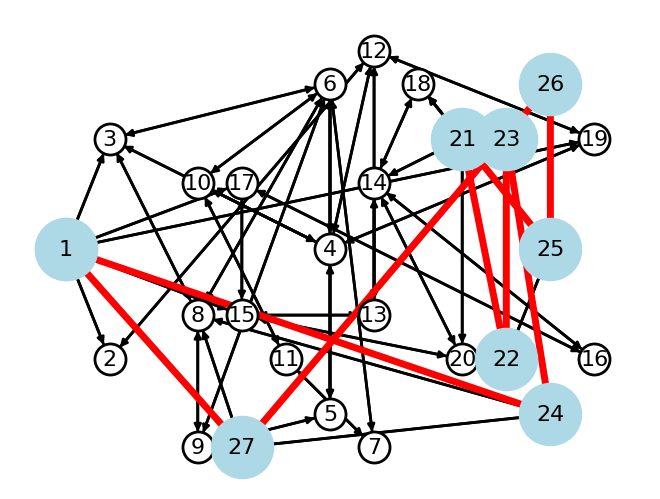

In [27]:
day = 4
truck = 2
print(best_solution[day][truck])
plot_graph(G, best_solution[day][truck])